# Tail Estimators

## Basics and Commonalities

The Tails module provides a variety of tail transformers that allow for the
extrapolation of development patterns beyond the end of the triangle.  Tail
factors are used extensively in commercial lines of business.

Every tail estimator produced a `tail_` attribute which represents the point
estimate of the tail of the Triangle.


In [24]:
import chainladder as cl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'svg'

In [ ]:
triangle = cl.load_sample('genins')
dev = cl.Development().fit_transform(triangle)
dev.cdf_

### Run Off

In addition to point estimates, tail estimators support run-off analysis.  The
`ldf_` and `cdf_` attribute splits the tail point estimate into enough
development patterns to allow for tail run-off to be examined for at least another
valuation year. For an annual `development_grain` grain, the development pattterns
include two additional patterns.

In [2]:
tail = cl.TailConstant(1.05).fit_transform(dev)
tail.cdf_

,12-Ult,24-Ult,36-Ult,48-Ult,60-Ult,72-Ult,84-Ult,96-Ult,108-Ult,120-Ult,132-Ult
(All),15.1689,4.3456,2.4870,1.7065,1.4537,1.3170,1.2124,1.1504,1.0686,1.0500,1.0254


For quarterly grain, there are five additional development patterns and for monthly
there are thirteen.



In [4]:
triangle = cl.load_sample('quarterly')['paid']
tail = cl.TailCurve().fit(triangle)
# Slice just the tail entries
tail.cdf_[~tail.ldf_.development.isin(triangle.link_ratio.development)]

,135-Ult,138-Ult,141-Ult,144-Ult,147-Ult
(All),1.0006,1.0005,1.0004,1.0004,1.0003


```{note}
The point estimate `tail_` of the tail is the CDF for 135-Ult. The remaining CDFs simply represent the run-off of this tail.
```

### Attachment Age

By default, tail estimators attach to the oldest `development` age of the `Triangle`.
In practice, the last several known development factors of a `Triangle` can be
unreliable and attaching the tail earlier and using it as a smoothing mechanism
is preferred.  All tail estimators have an `attachment_age` parameter that
allows you to select the development age to which the tail will attach.

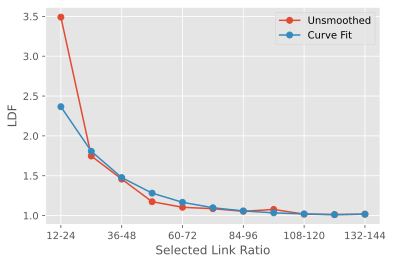

In [14]:
pd.concat((
    cl.TailCurve().fit(triangle).ldf_.T.iloc[:, 0].rename('Unsmoothed'),
    cl.TailCurve(attachment_age=12).fit(triangle).ldf_.T.iloc[:, 0].rename('Curve Fit')),
    axis=1).plot(marker='o', xlabel='Selected Link Ratio', ylabel='LDF');

Regardless of where you attach a tail, there will be incremental patterns to at
least one year past the end of the `Triangle` to support run-off analysis.

## TailConstant

:class:`TailConstant` allows you to input a tail factor as a constant.  This is
useful when relying on tail selections from an external source like industry data.

The tail factor supplied applies to all individual triangles contained within
the Triangle object.  If this is not the desired outcome, slicing individual
triangles and applying :class:`TailConstant` separately to each can be done.

### Decay

For run-off analysis, you can control the decay of your tail.  An exponential
`decay` parameter is also available to facilitate the run off analysis described
above.

In [18]:
tail_est = cl.TailConstant(tail=1.05, decay=0.95).fit_transform(triangle)
tail_est.ldf_

,12-24,24-36,36-48,48-60,60-72,72-84,84-96,96-108,108-120,120-132,132-144
(All),3.4906,1.7473,1.4574,1.1739,1.1038,1.0863,1.0539,1.0766,1.0177,1.0024,1.0474


As we can see in the example, the 5% tail in the example is split between the
amount to run-off over the subsequent calendar period **132-144**, and the
remainder, **144-Ult**.  The split is controlled by the `decay` parameter. We
can always reference our `tail_` point estimate.

In [19]:
tail_est.tail_

,120-Ult
(All),1.05


## TailCurve

:class:`TailCurve` allows for extrapolating a tail factor using curve fitting.
Currently, exponential decay of LDFs and inverse power curve (for slower decay)
are supported.


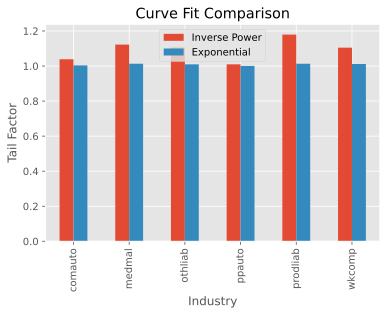

In [20]:
clrd = cl.load_sample('clrd').groupby('LOB').sum()['CumPaidLoss']
cdf_ip = cl.TailCurve(curve='inverse_power').fit(clrd)
cdf_xp = cl.TailCurve(curve='exponential').fit(clrd)
pd.concat((cdf_ip.tail_.rename("Inverse Power"),
           cdf_xp.tail_.rename("Exponential")), axis=1).plot(
        kind='bar', title='Curve Fit Comparison').set(
        xlabel='Industry', ylabel='Tail Factor');

In general, `inverse_power` fit produce more conservative tail estimates than
the `exponential` fit.  Both are fit using basic OLS regression on your selected
development patterns.

### Extrapolation Period

The `extrap_periods` parameter allows for limiting how far beyond the edge of
the triangle the tail should be extrapolated.  Results for the `inverse_power`
curve are sensitive to this parameter as it tends to converge slowly to its
asymptotic value.

```{eval-rst}
.. figure:: /auto_examples/images/sphx_glr_plot_extrap_period_001.png
   :target: ../auto_examples/plot_extrap_period.html
   :align: center
   :scale: 50%
```

### Regression parameters

Underlying the curve fit is an OLS regression which generates both a `slope_`
and `intercept_` term.

For the `exponential` curve fit with slope, b and intercept a, the tail factor
is:


$\prod_{i}^{N}1+exp(\beta X+\alpha )$

For the `inverse_power` curve, the tail factor is:

$\prod_{i}^{N}1+exp(\alpha) X^{\beta}$


Deriving the `tail_` factor manually:


In [32]:
tail_est = cl.TailCurve('exponential').fit(triangle)
tail_est.tail_

,120-Ult
(All),1.029499


A manual calculation of the same tail, using the formula above:

In [33]:
np.prod(
    (1+np.exp(
        np.arange(10, 10+tail_est.extrap_periods) * 
        tail_est.slope_.values + tail_est.intercept_.values)
    )
)

1.0294991710529175

In [34]:
tail_est = cl.TailCurve('inverse_power').fit(triangle)
tail_est.tail_

,120-Ult
(All),1.29243


In [37]:
np.prod(
    1 + np.exp(tail_est.intercept_.values) * 
    (np.arange(10, 10 + tail_est.extrap_periods) ** tail_est.slope_.values)
)

1.292430311543694

```{eval-rst}
.. topic:: References

  .. [CAS2013] `CAS Tail Factor Working Party, "The Estimation of Loss Development Tail
      Factors: A Summary Report", Casualty Actuarial Society E-Forum <https://www.casact.org/sites/default/files/database/forum_13fforum_02-tail-factors-working-party.pdf>`__
```

### TailBondy

:class:`TailBondy` allows for setting the tail factor using the Generalized Bondy
method.  The main estimate of the method is the Bondy exponent.  The tail factor
is can be described as a function of using an `ldf_` factor representative of the
last age in the Triangle and the Bondy exponent `b_`.

More formally, the tail factor is defined as:

  $F(n)=f(n-1)^{B}f(n-1)^{B^{2}}...=f(n-1)^{\frac{B}{1-B}}$

Rather than using the last known development factor explicitly, we estimate the
fitted LDF using the formula above along with the ``earliest_age`` parameter.
The following example shows how the :class:`TailBondy` estimator develops a
tail factor from ``b_``, the Bondy exponent.


In [51]:
triangle = cl.load_sample('tail_sample')
dev = cl.Development(average='simple').fit_transform(triangle)
# Estimate the Bondy Tail
tail_est = cl.TailBondy().fit(dev)
# Get last fitted LDF of the model
last_fitted_ldf = (tail_est.earliest_ldf_ ** (tail_est.b_ ** 8))
# Calculate the tail using the Bondy formula above
last_fitted_ldf ** (tail_est.b_ / (1-tail_est.b_))

,incurred,paid
Total,,
Total,1.004306,1.027756


In [53]:
tail_est.tail_.to_frame().T

,incurred,paid
0,1.004373,1.027763


```{eval-rst}
.. topic:: References

  .. [CAS2013] `CAS Tail Factor Working Party, "The Estimation of Loss Development Tail
      Factors: A Summary Report", Casualty Actuarial Society E-Forum <https://www.casact.org/sites/default/files/database/forum_13fforum_02-tail-factors-working-party.pdf>`__
```

## TailClark

:class:`TailClark` is a continuation of the :class:`ClarkLDF` model.  Familiarity
with :ref:`Growth Curve Fitting<clarkldf>` will aid in understanding this Estimator.
The growth curve approach used by Clark produces development patterns for any
age including ages beyond the edge of the Triangle.

An example completing Clark's model:


In [54]:
import chainladder as cl
genins = cl.load_sample('genins')
dev = cl.ClarkLDF()
tail_est = cl.TailClark()
tail_est.fit(dev.fit_transform(genins)).cdf_

,12-Ult,24-Ult,36-Ult,48-Ult,60-Ult,72-Ult,84-Ult,96-Ult,108-Ult,120-Ult,132-Ult
(All),21.0878,5.1497,2.9932,2.2297,1.8572,1.6427,1.5057,1.4118,1.3440,1.2933,1.2540


### Truncated pattterns

Clark warns of the dangers of extrapolating too far beyond the edge of a Triangle,
particularly with a heavy tailed distribution.  In these cases, it is suggested that
a suitable cut-off age or ``truncation_age`` be established where losses are considered
fully developed.

In [55]:
tail_est = cl.TailClark(truncation_age=245)
tail_est.fit(dev.fit_transform(genins)).cdf_

,12-Ult,24-Ult,36-Ult,48-Ult,60-Ult,72-Ult,84-Ult,96-Ult,108-Ult,120-Ult,132-Ult
(All),19.2093,4.6910,2.7266,2.0310,1.6918,1.4964,1.3715,1.2860,1.2243,1.1781,1.1423


```{eval-rst}
.. topic:: References

  .. [CD2003] `Clark, David R., "LDF Curve-Fitting and Stochastic Reserving: A Maximum Likelihood Approach",
               Casualty Actuarial Society Forum, Fall, 2003 <https://www.casact.org/sites/default/files/database/forum_03fforum_03ff041.pdf>`__
```